## Sellers function
#### A Naive Congestion Pricing Genco model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math




In [ ]:
supply_curve = NCpGenco()
asks = supply_curve.asks()





asks_q = asks[:,1].cumsum()
xmax = asks_q
xmin = np.append(0,asks_q[:-1])

plt.hlines(y = asks[:,0], xmin = xmin, xmax = xmax, colors = "grey")
plt.scatter(xmax, asks[:,0], marker='D', s=5 ,c ="black")
plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "-.")

plt.show()


In [ ]:
print(asks[:,1])

print(asks[10:,1])

In [ ]:
# supply_curve = NCpGenco()
# asks = supply_curve.asks()
# requirements = np.round(np.random.uniform(0.5,50,size=(2,)),2)
# print(asks.flatten())
# print(requirements)
# # np.array([asks.flatten(),requirements])
# np.append(asks.flatten(),requirements)


# from gymnasium.spaces import Discrete, MultiDiscrete, Box, Tuple, Dict

# bids_space = Tuple((Box(1,100,shape=(31,),dtype=np.float32),Box(0,1500,shape=(31,),dtype=np.float32)))

# bids_space.sample()


# observation_space = Dict({ "asks" : bids_space,  "requirements" : Box(0.5,50,shape=(2,),dtype=np.float32)})

# observation_space.sample()

# observation = {"ask space" : asks, "requirements" : requirements}
# observations = { i: observation for i in range(3) }
# print(observations)
# # observations   = { 
# #             "prisoner": {"observation": observation, "action_mask": [0, 1, 1, 0]},
# #             "guard": {"observation": observation, "action_mask": [1, 0, 0, 1]},
# #         }

### Flatten observation space

In [ ]:
from gymnasium.spaces import Box,Dict
item1=Box(10,100,shape=(1,),dtype=np.float32) 
item2=Box(10,100,shape=(1,),dtype=np.float32) 

item4 = Dict({"item1" : item1, "item2" : item2})

print(item4["item1"].low[0])
# item3 = Box(min(item1.low[0],item2.low[0]),max(item1.high[0],item2.high[0]),shape=(item1.shape[0]+item2.shape[0],))

## Auction mechanism

In [ ]:
from pettingzoo.test import parallel_api_test
from auction_env import AuctionEnv, FlattenObservationSpace

if __name__ == "__main__":
    env = FlattenObservationSpace()
    # env.reset()
    # a=set(env.agents[:])
    # print('l', a)
    # env.render_mode = "human"
    parallel_api_test(env, num_cycles=10000000)


## To verify the clearing mechanism and environment

In [ ]:
env = AuctionEnv()
env.reset()
actions = { agent : env.action_space(agent).sample() for agent in env.agents}
env.render_mode = "human"
observations, rewards, terminations, truncations, infos = env.step(actions)

print(actions)
print(env.asks)
print(len(env.asks))
print(env.last_cl_ask_index)
print(env.mcp)
print(" ")

In [ ]:
print(observations)

In [ ]:
import numpy as np
def flatten_obs(observation):
    new_obs = np.array([])
    for k,v in observation.items():
        new_obs = np.append(new_obs,v.flatten())
            
    return new_obs

flat_obs=flatten_obs(observations[0])

In [1]:
import copy
import random
# from typing import Dict, List, Tuple
import typing

# import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size,2], dtype=np.float32) # action space
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        # print(act,"action isnide memory")
        self.acts_buf[self.ptr] = act

        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> typing.Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [3]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

In [4]:
# Class NormalNoise:
#     def __init__(self):
        

In [5]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, out_dim)
        
        # self.out.weight.data.uniform_(-init_w, init_w)
        # self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x)
        
        return action
    
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)
        
        # self.out.weight.data.uniform_(-init_w, init_w)
        # self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        # print((state,action),"state,action")
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

In [17]:
from auction_env import FlattenObsSingleAgent

PATH = "model.pt"
VAR = 50
VAR_DECAY = 0.99999
VAR_MIN = 2


class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: FlattenObsSingleAgent,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 1,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""
        obs_dim = env.observation_space(0).shape[0] ## Single agent
        # print("obs_dim", obs_dim)
        action_dim = env.action_space(0).shape[1] ## Single agent
        # print("action_dim",action_dim)
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.best_reward = -7500000    
        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )
        # self.noise = np.tile(self.noise,(1,1))
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3,weight_decay=1e-4) #1e-5
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-2,weight_decay=1e-4) # 1e-4
        
        # transition to store in memory
        self.transition = list()
        # self.gauss_var = 250
        # total steps count
        self.total_step = 0
        self.var = VAR
        


        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space(0).sample() ## single agent
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
            # if self.total_step % 1000 == 0:
                # print(selected_action,"select_action_network")
            # selected_action = np.tile(selected_action,(1,1))
        # if self.total_step % 1000 == 0:
            # print(selected_action.flatten(),"action")
        # add noise for exploration during training
        selected_action_fl=selected_action.flatten()
        # self.gauss_var = VAR_MIN + (VAR - VAR_MIN) * np.exp(-(1 - VAR_DECAY) * self.total_step) 
        # print(self.gauss_var,"variance")
        self.transition = [state, selected_action_fl]
        if not self.is_test:
            # noise = self.noise.sample()
            noise = np.tile(np.random.normal(0,self.var,(2,)),(1,1))
            # noise = np.random.normal(0,self.gauss_var,(2,))
            # noise = np.tile(noise,(1,1)) # Added this
            
            # print(noise,"noise","noised action" ,selected_action_fl+noise)
        else: 
            noise = 0   
        # print(selected_action,"selected action")
        # if self.total_step % 1000 == 0:
        #     print(VAR,noise)
        self.var = max(VAR_MIN, self.var * VAR_DECAY)
        clip_array_min = [0.5,0]
        clip_array_max = [500,1500]
        selected_action_fl = np.clip(selected_action_fl + noise, clip_array_min,clip_array_max)
        
        # print(state,"state")
        return selected_action_fl
    
    def step(self, action: np.ndarray) -> typing.Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""

        action_unsqueeze = np.tile(action,(1,1))
        next_state, reward, done, _ ,_ = self.env.step(action_unsqueeze) # new gym syntax
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        # print(state.shape,"state")
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 2)).to(device)
        # print(action.shape,"action")
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # if self.total_step % 1000 == 0:
        #     for p in self.critic.parameters():
        #         print(p.grad.norm().item(),"critic")
        self.critic_optimizer.step()
                
        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # if self.total_step % 1000 == 0:
        #     for p in self.actor.parameters():
        #         print(p.grad.norm().item(),"actor")
        #     print(actor_loss.item(),"actor_loss")
        #     print("actor details", self.critic(state, self.actor(state)))
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset()
        # print("state",state)
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            # print(action,"action")
            next_state, reward, done = self.step(action)
            # self.bid_vals = env.bid_vals
            # print(self.bid_vals,"bid_vals")
            state = next_state
            score += reward

            # if episode ends
            if done:         
                state, _ = env.reset()
                # print(score)
                # break
                scores.append(score)
                if score > self.best_reward:
                    torch.save({'Actor model': self.actor.state_dict(),
                                  'Critic model': self.critic.state_dict(),
                                  'Actor optimizer': self.actor_optimizer.state_dict(),
                                  'Critic optimizer': self.critic_optimizer.state_dict(),
                                  'episode' : self.total_step}, PATH)
                    self.best_reward = score
                score = 0
                
            

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                # print(actor_loss.item(),"actor loss")
                # print(critic_loss.item(),"critic loss")
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0 and False:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
            if self.total_step % 20000 == 0:
                self.test()
                self.env.reset()
                self.env.render_mode = None

                # for _ in range(TEST):
                    # scores = []
                    # score = self.test()
                    # scores.append(score)
                    # self.env.reset()
                    # self.env.render_mode = None

            
          
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state, _ = self.env.reset()

        # print(state)
        # print(self.env.requirements[0],"requirements")
        # print(self.env.timestep)
        done = False
        score = 0
        clear_output(True)
        
        self.env.render_mode = "human"
        # self.load()
        # frames = []
        while not done:
            # frames.append(self.env.render(mode="rgb_array"))
            print(self.env.timestep,"timestep")
            print(self.env.requirements[0],"requirements")
            action = self.select_action(state)
            # print(action,"action")
            # action = np.tile(action,(1,1))
            next_state, reward, done = self.step(action)
            
            state = next_state
            score += reward
            print(action,"action")

        print("score: ", score)
        
        # self.env.close()
        
        
    def load(self):
        checkpoint = torch.load(PATH)
        self.actor.load_state_dict(checkpoint['Actor model'])
        self.critic.load_state_dict(checkpoint['Critic model'])
        self.actor_optimizer.load_state_dict(checkpoint['Actor optimizer'])
        self.critic_optimizer.load_state_dict(checkpoint['Critic optimizer'])



    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: typing.List[float], 
        actor_losses: typing.List[float], 
        critic_losses: typing.List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: typing.List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores)}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [18]:
# env = AuctionEnv()
# env_fl = FlattenObsSingleAgent(env)

# obs = env.observation_space(0).sample()
# obs_fl = env_fl.observation_space(0)
# print(env.observation_space(0).sample())
# print(obs_fl.sample())




In [19]:
num_frames = 100000
memory_size = 10000
batch_size = 256
ou_noise_theta = 0.01
ou_noise_sigma = 0.1
initial_random_steps = 10000
tau = 1e-2

env = FlattenObsSingleAgent()
print(env.requirements[0])
agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    tau,
    initial_random_steps=initial_random_steps
)

1500.0
cpu


/home/bharat/Documents/Simulations/multi_agent_learning/.venv/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [20]:
## test
dim = env.observation_space(0).shape[0]
actor = Actor(dim,2)
state=env.observation_space(0).sample()
print('action',actor(torch.FloatTensor(state)))
# for p in actor.parameters():
#     print(p.grad.norm().item(),"actor")


action tensor([-41.8781,  -4.0261], grad_fn=<AddBackward0>)


0 timestep
1500.0 requirements


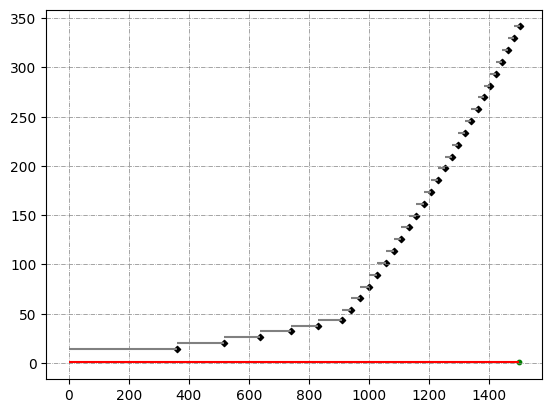

[5.0e-01 1.5e+03] action
1 timestep
1500.0 requirements


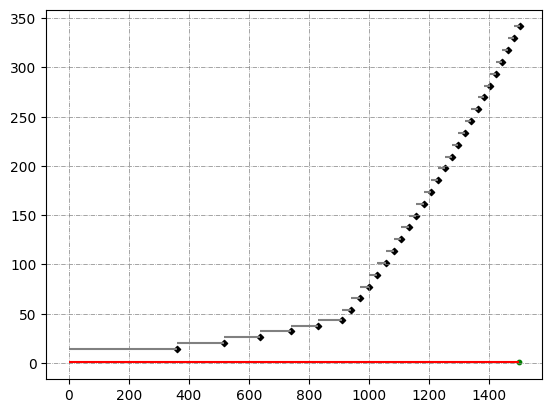

[5.0e-01 1.5e+03] action
2 timestep
1500.0 requirements


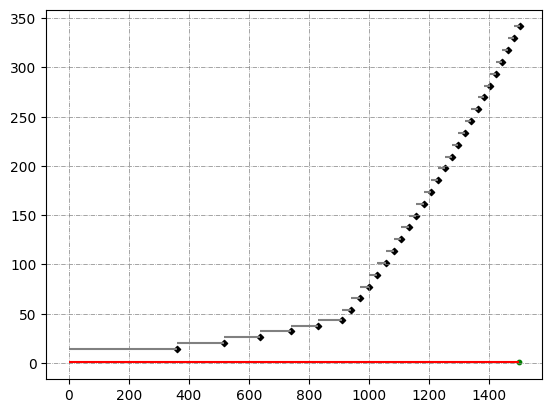

[5.0e-01 1.5e+03] action
3 timestep
1500.0 requirements


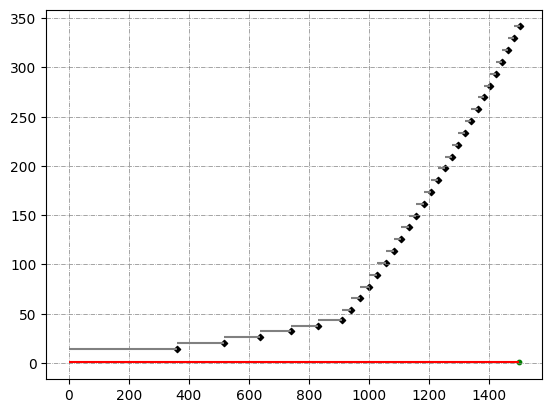

[5.0e-01 1.5e+03] action
4 timestep
1500.0 requirements


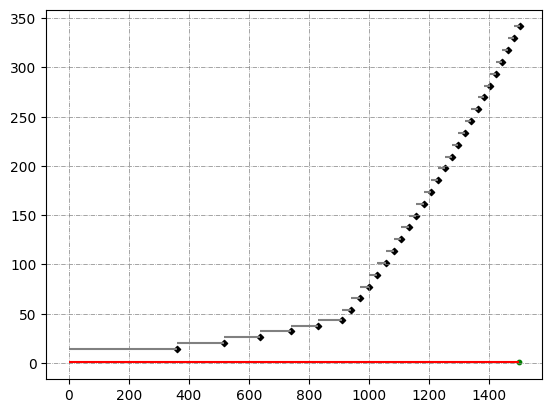

[5.0e-01 1.5e+03] action
5 timestep
1500.0 requirements


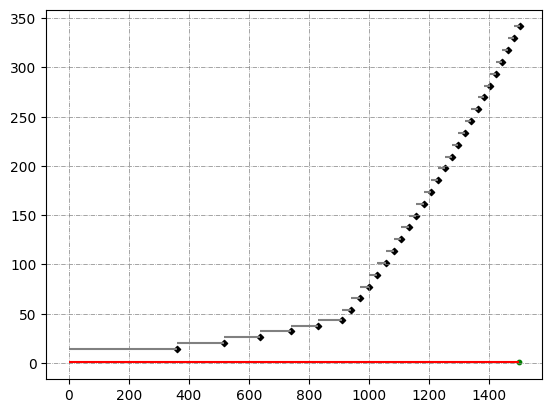

[5.0e-01 1.5e+03] action
6 timestep
1500.0 requirements


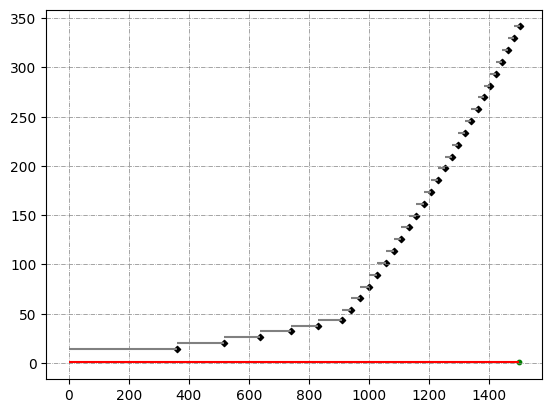

[5.0e-01 1.5e+03] action
7 timestep
1500.0 requirements


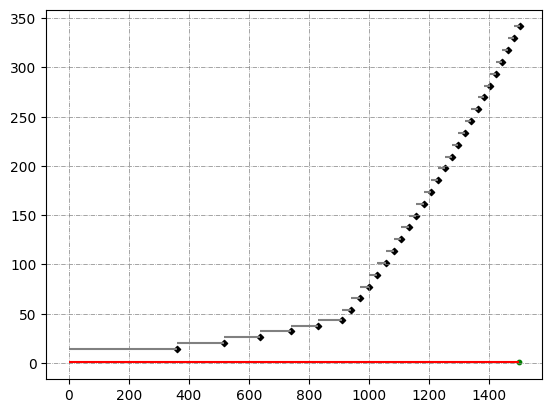

[5.0e-01 1.5e+03] action
8 timestep
1500.0 requirements


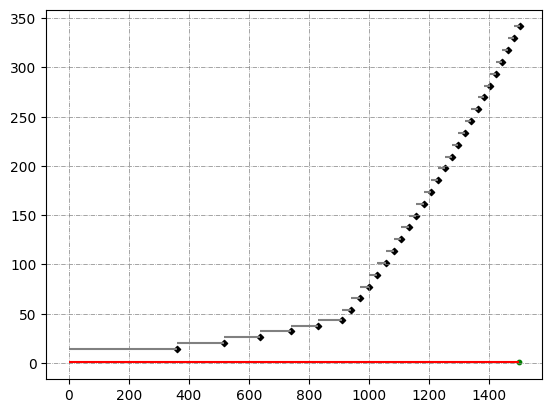

[5.0e-01 1.5e+03] action
9 timestep
1500.0 requirements


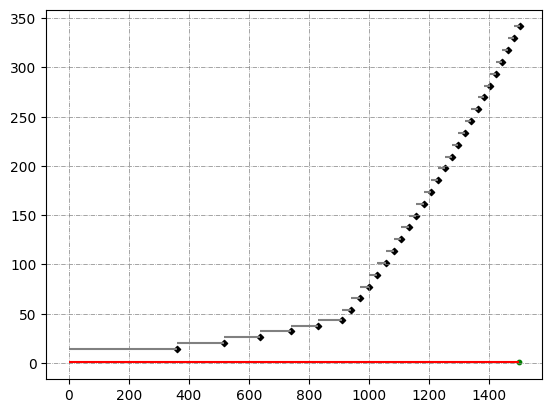

[5.0e-01 1.5e+03] action
10 timestep
1500.0 requirements


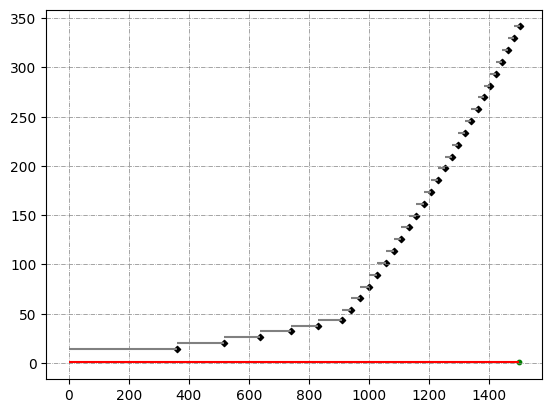

[5.0e-01 1.5e+03] action
11 timestep
1500.0 requirements


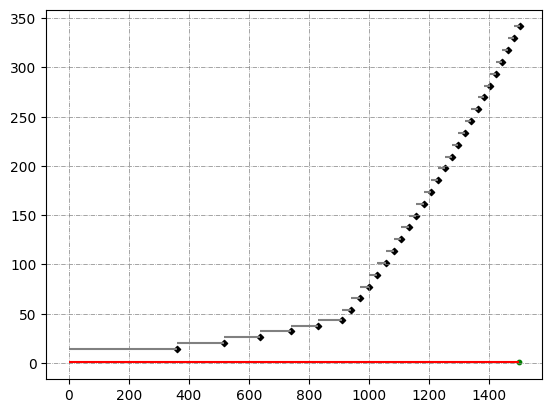

[5.0e-01 1.5e+03] action
12 timestep
1500.0 requirements


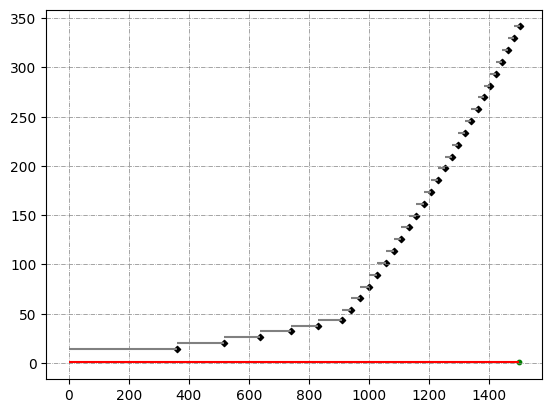

[5.0e-01 1.5e+03] action
13 timestep
1500.0 requirements


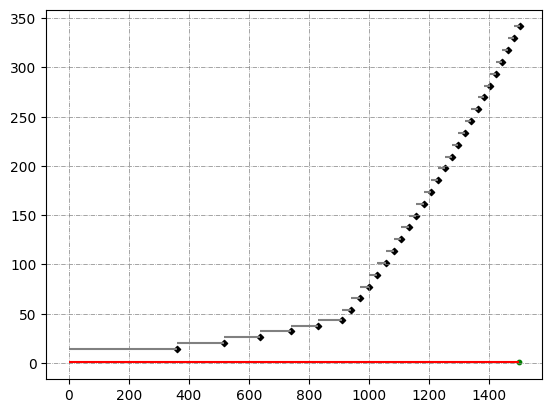

[5.0e-01 1.5e+03] action
14 timestep
1500.0 requirements


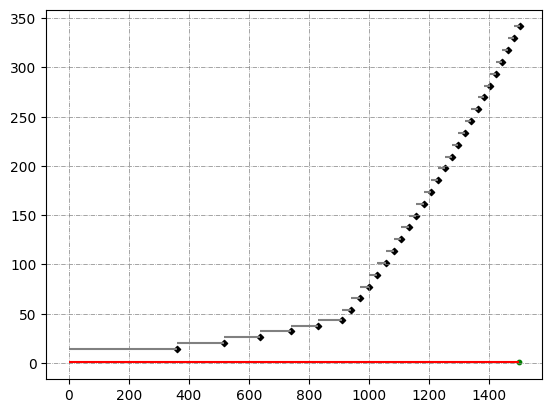

[5.0e-01 1.5e+03] action
15 timestep
1500.0 requirements


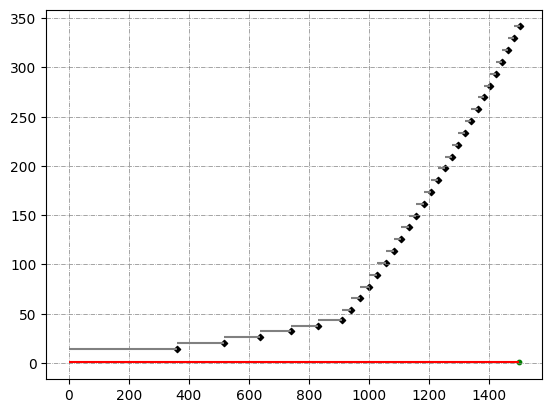

[5.0e-01 1.5e+03] action
16 timestep
1500.0 requirements


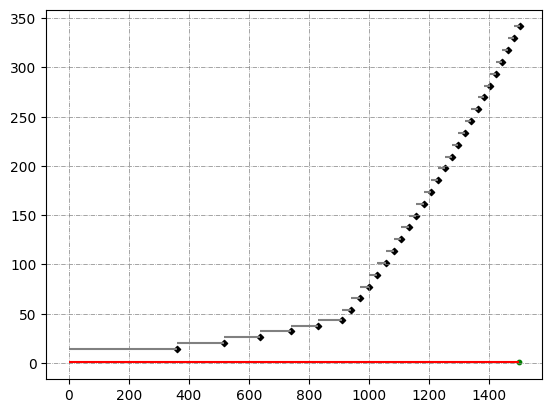

[5.0e-01 1.5e+03] action
17 timestep
1500.0 requirements


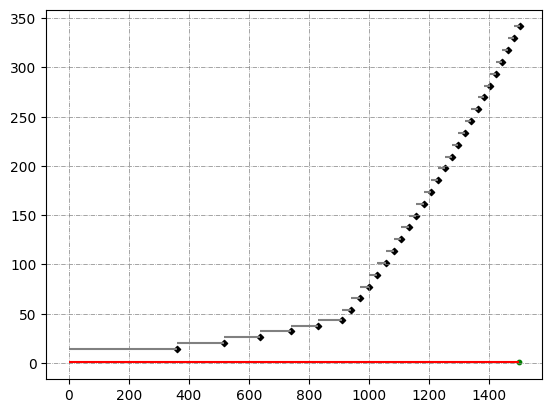

[5.0e-01 1.5e+03] action
18 timestep
1500.0 requirements


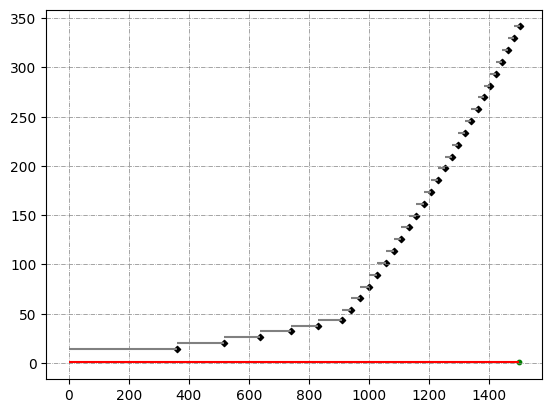

[5.0e-01 1.5e+03] action
19 timestep
1500.0 requirements


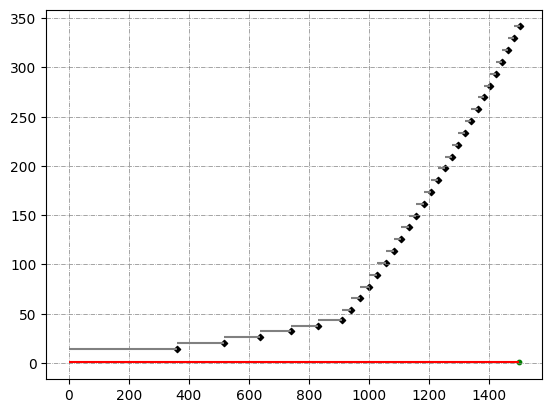

[5.0e-01 1.5e+03] action
20 timestep
1500.0 requirements


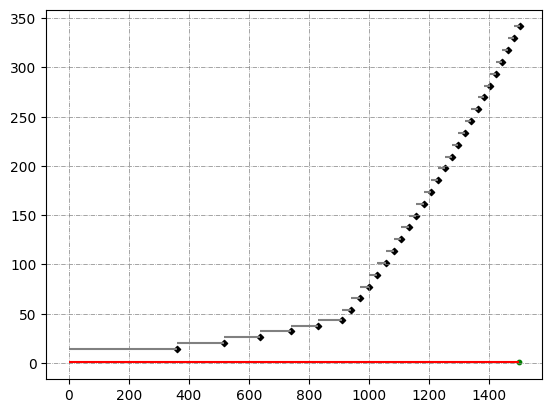

[5.0e-01 1.5e+03] action
21 timestep
1500.0 requirements


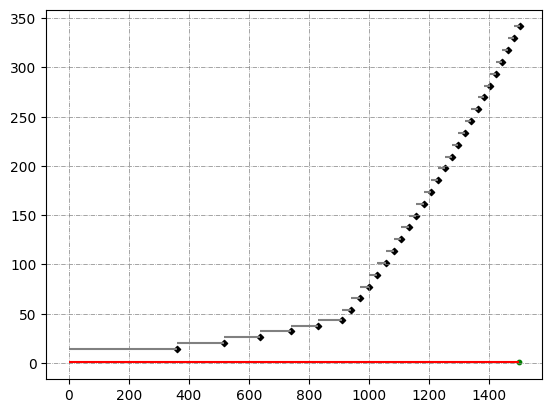

[5.0e-01 1.5e+03] action
22 timestep
1500.0 requirements


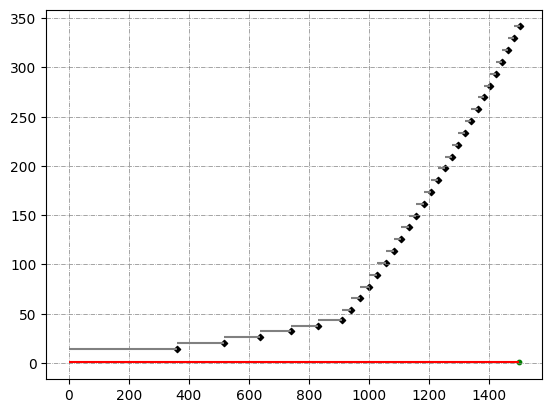

[5.0e-01 1.5e+03] action
23 timestep
1500.0 requirements


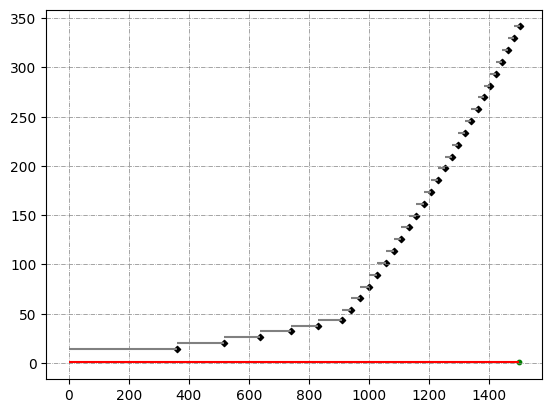

[5.0e-01 1.5e+03] action
24 timestep
1500.0 requirements
[5.0e-01 1.5e+03] action
score:  -7500000.0


KeyboardInterrupt: 

In [21]:
agent.train(num_frames)




0 timestep
1500.0 requirements


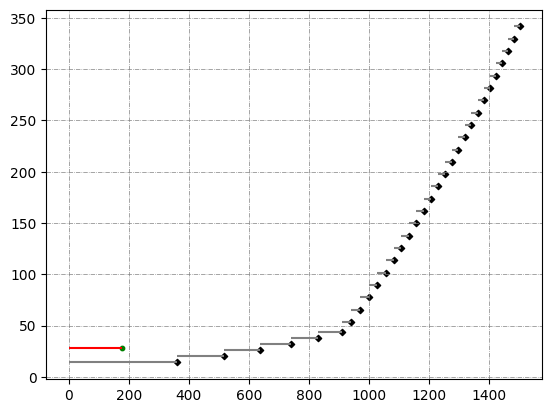

[ 27.90500641 178.13409424] action
1 timestep
1321.8659057617188 requirements


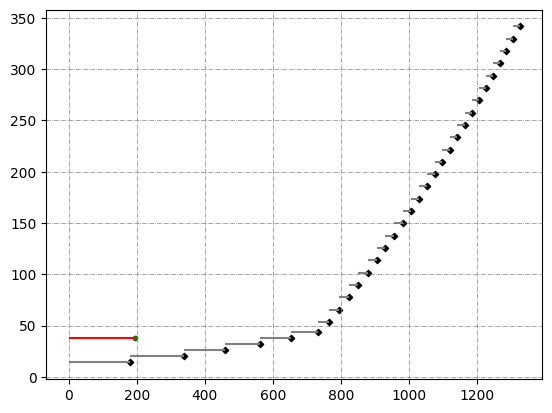

[ 37.55571747 196.32333374] action
2 timestep
1125.5425720214844 requirements


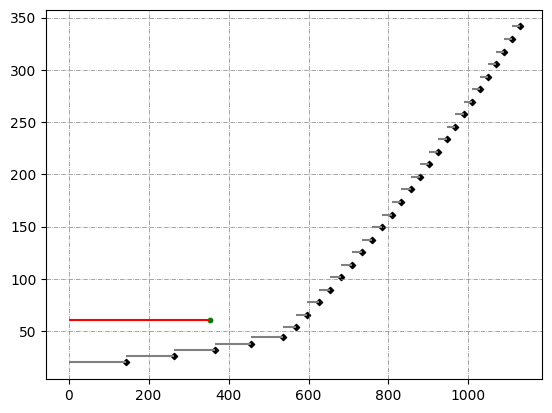

[ 60.24464417 353.11038208] action
3 timestep
772.4321899414062 requirements


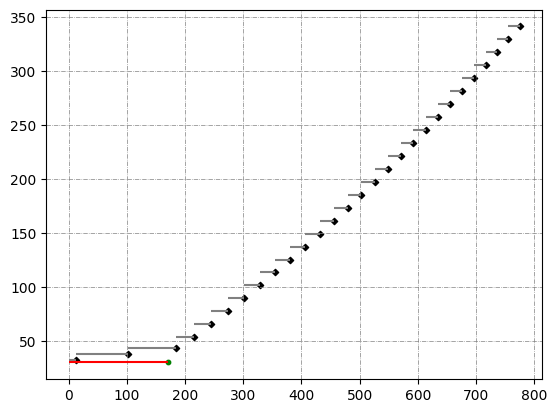

[ 30.1455822  170.78421021] action
4 timestep
772.4321899414062 requirements


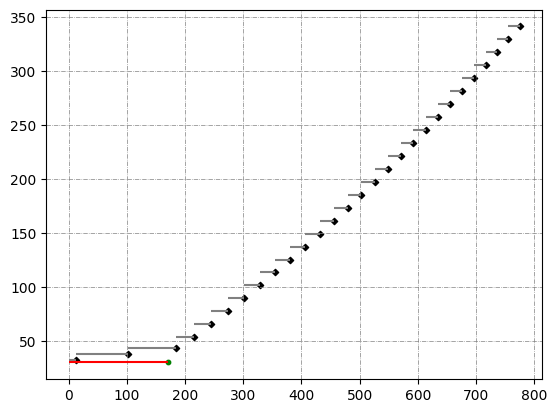

[ 30.1455822  170.78421021] action
5 timestep
772.4321899414062 requirements


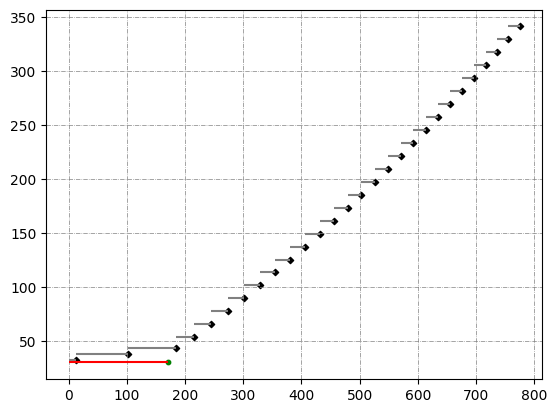

[ 30.1455822  170.78421021] action
6 timestep
772.4321899414062 requirements


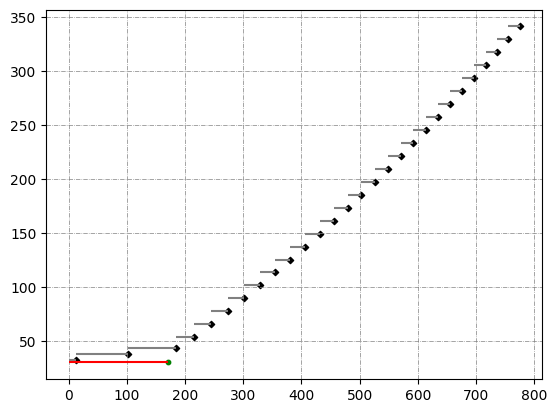

[ 30.1455822  170.78421021] action
7 timestep
772.4321899414062 requirements


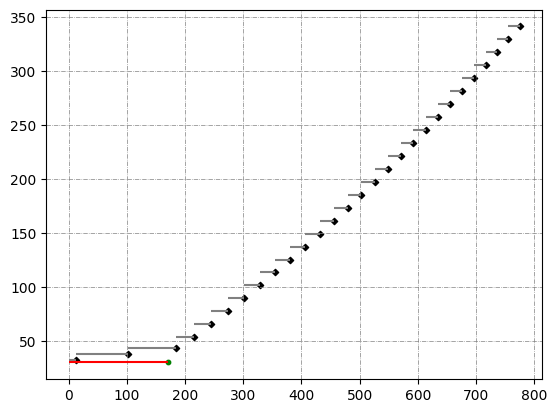

[ 30.1455822  170.78421021] action
8 timestep
772.4321899414062 requirements


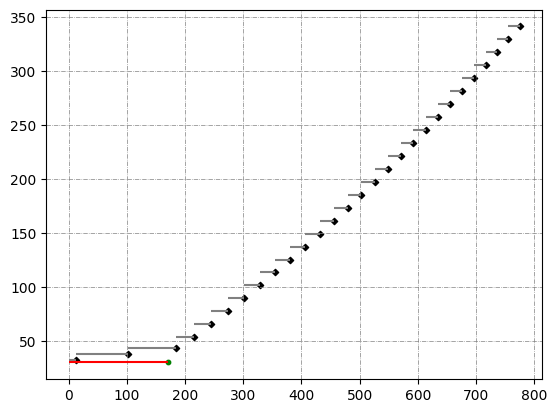

[ 30.1455822  170.78421021] action
9 timestep
772.4321899414062 requirements


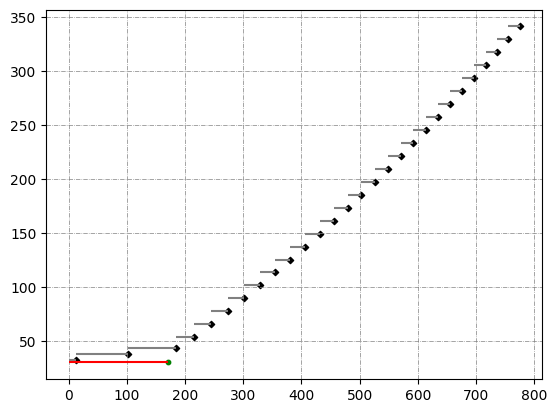

[ 30.1455822  170.78421021] action
10 timestep
772.4321899414062 requirements


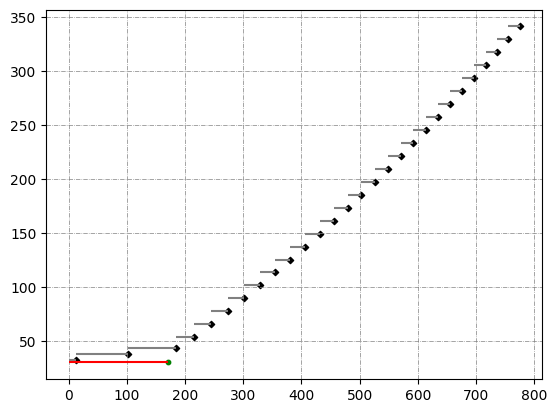

[ 30.1455822  170.78421021] action
11 timestep
772.4321899414062 requirements


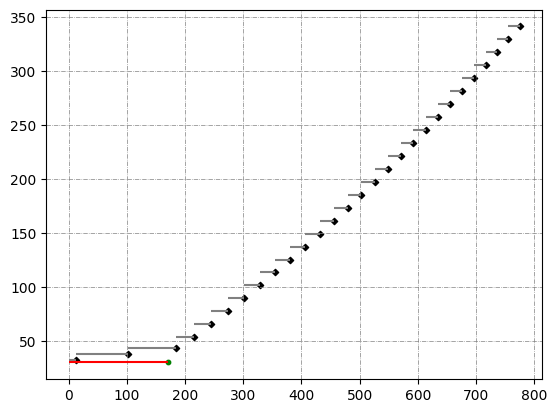

[ 30.1455822  170.78421021] action
12 timestep
772.4321899414062 requirements


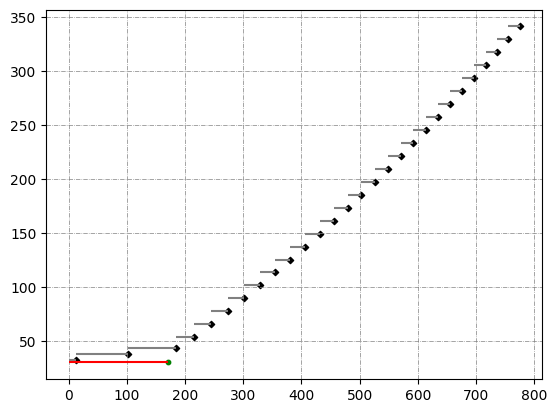

[ 30.1455822  170.78421021] action
13 timestep
772.4321899414062 requirements


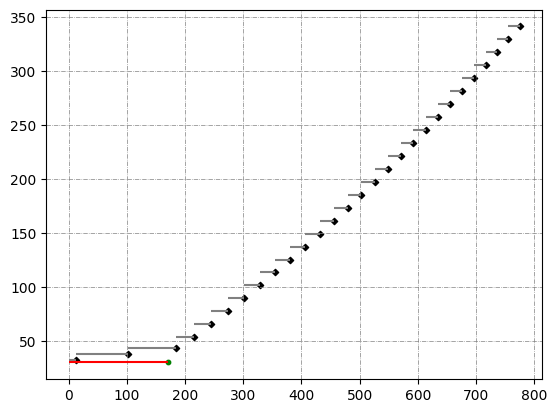

[ 30.1455822  170.78421021] action
14 timestep
772.4321899414062 requirements


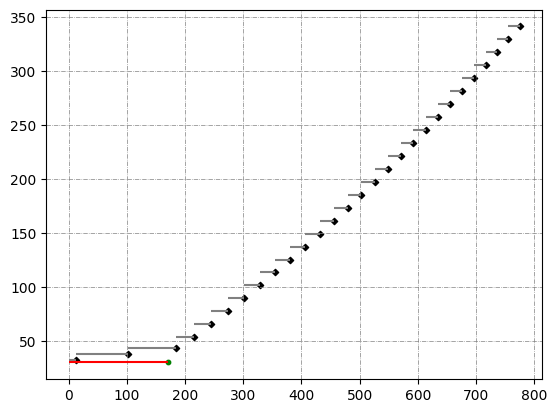

[ 30.1455822  170.78421021] action
15 timestep
772.4321899414062 requirements


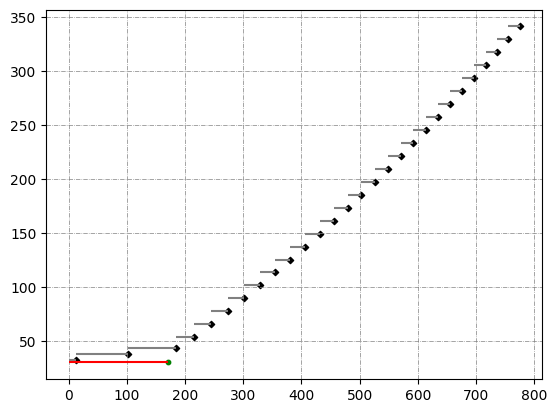

[ 30.1455822  170.78421021] action
16 timestep
772.4321899414062 requirements


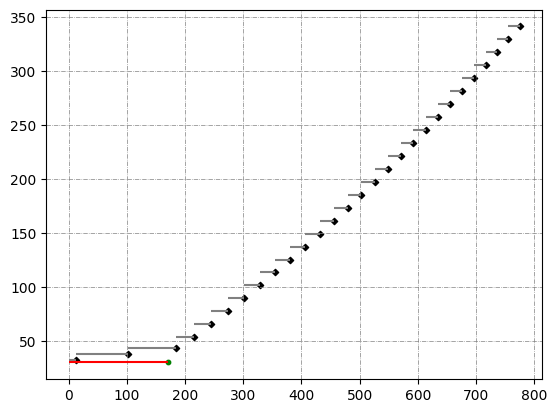

[ 30.1455822  170.78421021] action
17 timestep
772.4321899414062 requirements


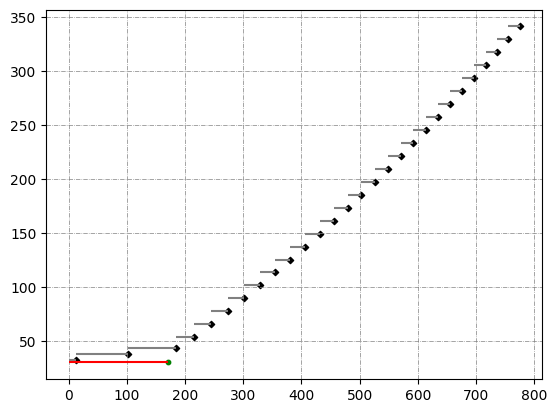

[ 30.1455822  170.78421021] action
18 timestep
772.4321899414062 requirements


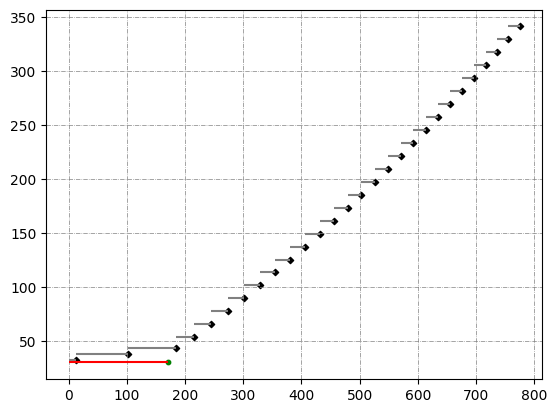

[ 30.1455822  170.78421021] action
19 timestep
772.4321899414062 requirements


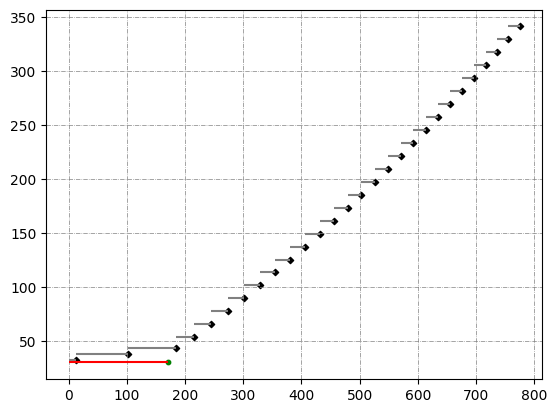

[ 30.1455822  170.78421021] action
20 timestep
772.4321899414062 requirements


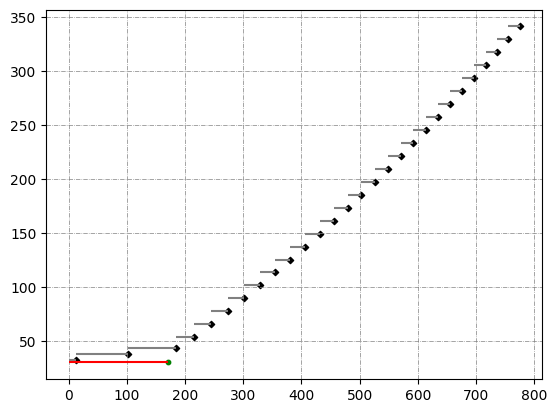

[ 30.1455822  170.78421021] action
21 timestep
772.4321899414062 requirements


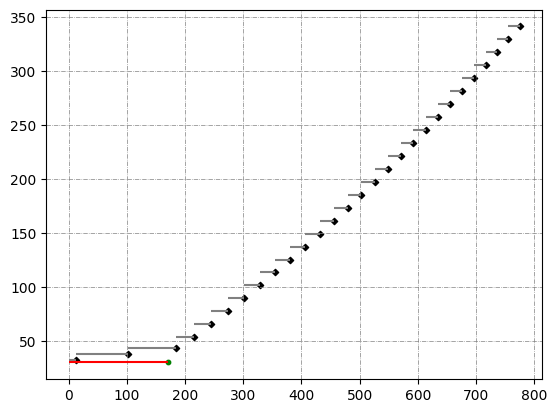

[ 30.1455822  170.78421021] action
22 timestep
772.4321899414062 requirements


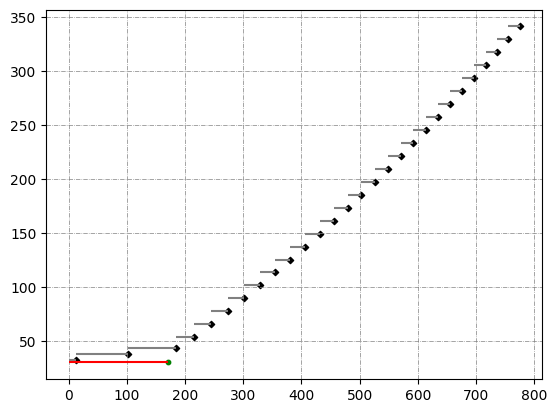

[ 30.1455822  170.78421021] action
23 timestep
772.4321899414062 requirements


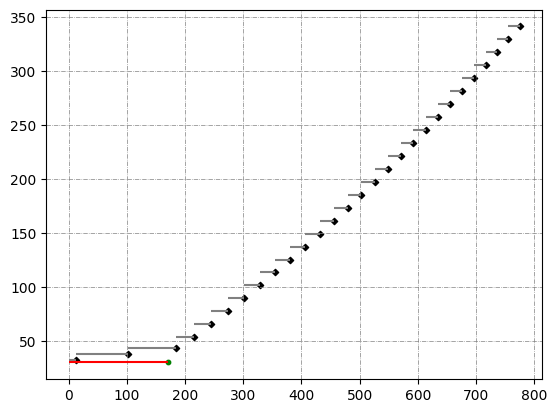

[ 30.1455822  170.78421021] action
24 timestep
772.4321899414062 requirements
[ 30.1455822  170.78421021] action


-3887829.340824931

In [11]:
agent.test()

In [ ]:
bid_vals = agent.bid_vals
print(bid_vals)
# print(sorted(range(len(bid_vals)), key=lambda k: (-bid_vals[k][0],-bid_vals[k][1])))

In [ ]:
env2 = FlattenObservationSpace()
observations, _ = env2.reset()

In [ ]:
act = np.array([[0, 0]])
ou_noise_theta = 0.01
ou_noise_sigma = 0.1
noise23 = OUNoise(
            2,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )


noise = np.tile(noise23.sample(),(1,1))
print(noise)

clip_array_min = np.tile([0.5,0],(1,1))
clip_array_max = np.tile([500,500],(1,1))
selected_action = np.clip(act + noise,clip_array_min,clip_array_max)

print(selected_action)
print("action")

In [ ]:
import math
var = 250
np.random.normal(0,var,(2,))

In [8]:
import numpy as np
np.sort(np.round(np.random.uniform(20,100,size=(4,)),2))[::-1]

array([72.34, 45.61, 45.46, 28.81])